In [1]:
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using Dates: DateTime,datetime2unix
using Dates
using RollingFunctions: rolling
using Statistics
using StatsBase
using Plots
using LinearAlgebra
using ToeplitzMatrices
using Random
using Distributions


function apply_differencing(s, d=1)
    differenced_series = s
    init_vals = []
    for i in 1:d
        push!(init_vals, differenced_series[1])
        differenced_series = diff(differenced_series)
    end
    return differenced_series, init_vals
end
function undo_differencing(s, inits, d=1)
    # assert(d == length(inits), "The number of initial values should be equal to the differencing order")
    undifferenced_series = s
    # println(cumsum(undifferenced_series) .+ 6)
    for i in 1:d
        current_init = pop!(inits) # pop the last element
        undifferenced_series = [current_init; cumsum(undifferenced_series) .+ current_init]
    end
    return undifferenced_series
end

function arima(series, p::Int, d::Int, q::Int, F::Int)
    # Apply differencing
    differenced_series, inits = apply_differencing(series, d)
    ar_predictions = zeros(F)
    # Calculate the autocorrelation matrix
    autocorr = autocor(differenced_series)
    # Create the Toeplitz matrix
    R_matrix = Toeplitz(autocorr[1:p], autocorr[1:p])
    r_vector = autocorr[2:p+1]
    # ar_coeffs = []

    # # Solve the Yule-Walker equations
    ar_coeffs = R_matrix \ r_vector
    if p > 0
        for i in 1:F

            coeffs = R_matrix \ autocorr[1+i:p+i]
            ar_predictions[i] = sum(differenced_series[end-p+1:end] .* reverse(coeffs))
        end
        
    end

    ma_predictions = zeros(F)
    if q > 0
        sample_var = var(diff(differenced_series))
        ma_var = (1/(length(differenced_series) - p - 1)) * sum((differenced_series[i+p+1] - sum(differenced_series[i+1:i+p] .* reverse(ar_coeffs)))^2 for i in 1:length(differenced_series)-p-1)
        ma_samples = rand(Normal(0, sqrt(ma_var/(length(differenced_series) - p - 1))), F)
        ma_predictions = ma_samples
    end
    # Forecast
    forecast = ar_predictions .+ ma_predictions
    # Undo differencing
    restored_series = undo_differencing([differenced_series;  forecast], inits, d)
    return restored_series[end-F+1:end]
end

arima (generic function with 1 method)

In [24]:
function run_arima(data; p=1, d=1, q=1, F=1, reparameterise_window=0, dates=Nothing)
    step_map = Dict()
    step_error = []
    load_idx = max(p, reparameterise_window, round(Int, length(data) / 2))
    loading_data = data[1:load_idx]
    running_data = data[load_idx+1:end]

    function run_func(x)
        all_data = [loading_data; x]
        if reparameterise_window != 0
            all_data = all_data[end-reparameterise_window+1:end]
        end
        forecast = arima(all_data, p, d, q, F)
        return forecast
    end

    if reparameterise_window == 0
        reparameterise_window = length(running_data)
    end
    forecast = running(run_func, running_data, reparameterise_window)
    # println(forecast)
    for i in 1:F
        if i == 1
            fill_data = []
        else
            fill_data = running_data[2:i]
        end
        fill_data = running_data[1:i]
        step_map[i] = [fill_data;collect(Iterators.flatten(f[i] for f in forecast))][1:length(running_data)]

        e = step_map[i][i+1:end] .- running_data[i+1:end]
        push!(step_error, mean((e).^2))
    end

    if dates != Nothing
        ticks = Dates.format.(dates, "dd-mm-yyyy")
        step_size = round(Int, length(running_data) / 10)
        tick_idx = 1:step_size:length(ticks)
        println(tick_idx)
        step_plot = plot(running_data[F+1:end], xticks = (1:step_size:length(running_data),ticks[end-length(running_data)+1:step_size:end]), xrot=60, label="Actual", size=(800, 400))
    else
        step_plot = plot(running_data[F+1:end], label="Actual", size=(800, 400))
    end
    for i in 1:F
        plot!(step_map[i][F+1:end], label="Forecast $i step")
    end
    return step_plot, step_error
end

run_arima (generic function with 1 method)

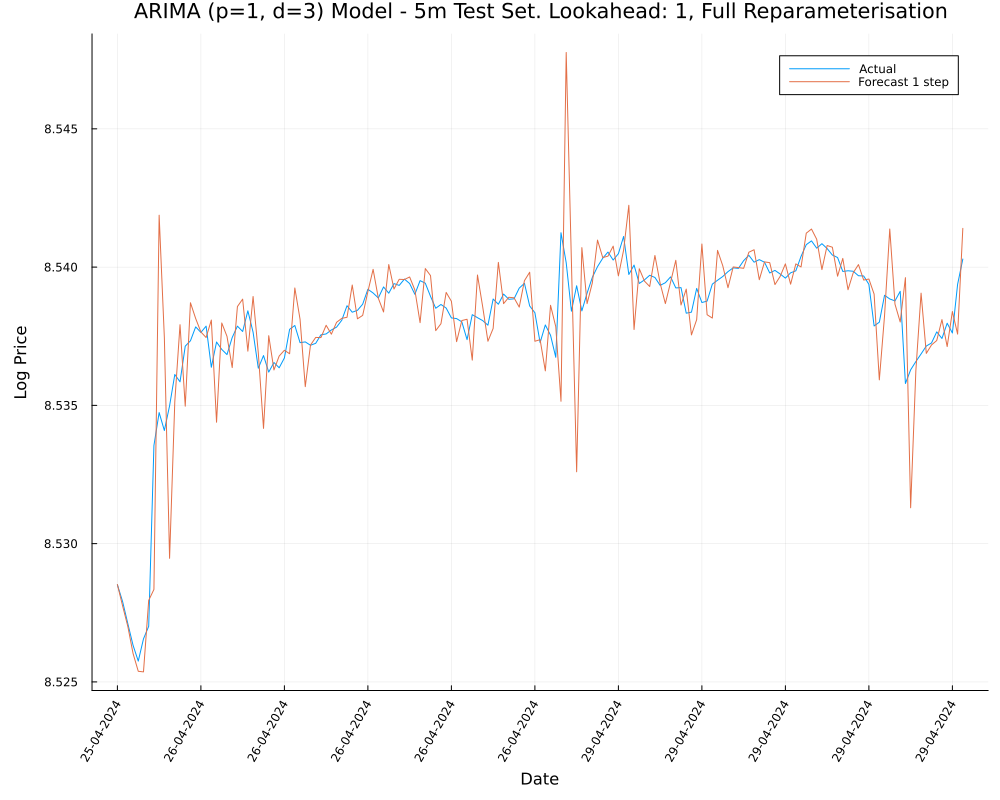

MADS Run Summary
------------------------------------------------
Feasible Solution           nothing
Feasible Cost               nothing
Infeasible Solution         [1.0, 3.0, 1.0, 0.0]
Infeasible Cost             3.513159565131113e-6

Iterations                  51
Function Evaluations        3
Cache hits                  0
Optimization Status         Mesh Precision limit

Runtime                     0.5755741596221924
Search Time                 6.877999999999999e-6
Poll Time                   0.010990559
Blackbox Evaluation Time    0.2633584
1:16:1633
errors full reparam: 2.7172315958075688e-6
MADS Run Summary
-------------------------------------------------
Feasible Solution           nothing
Feasible Cost               nothing
Infeasible Solution         [2.0, 2.0, 2.0, 52.0]
Infeasible Cost             2.447158829984415e-6

Iterations                  51
Function Evaluations        5
Cache hits                  0
Optimization Status         Mesh Precision limit

Runtime        

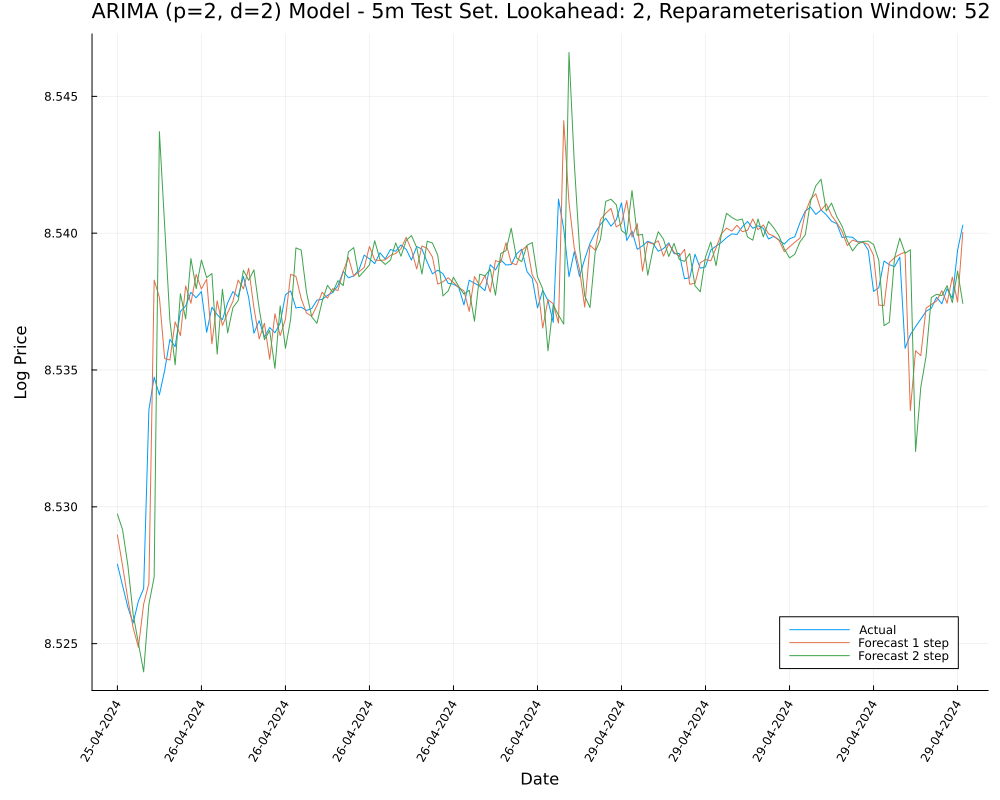

In [53]:
using RollingFunctions
using DirectSearch

freq = "5m"

unix(x) = string(round(Int, datetime2unix(DateTime(x))))


price = log.(sp500.close)
train_idx = round(Int, length(price) * 0.8)
train, test = price[1:train_idx], price[train_idx+1:end]

function obj(x)
    params = round.(Int, x)
    # println("evaluating: ", params)
    obj_plot, errors = run_arima(train; p=params[1], d=params[2], q=1, F=params[3], reparameterise_window=params[4])
    reparam_type = params[4] == 0 ? "Full Reparameterisation" : "Reparameterisation Window: $(params[4])"
    folder = params[4] == 0 ? "full_reparam" : "partial_reparam"
    plot!(obj_plot; title="ARIMA $(params[1:2]) Model - Train Set. Lookahead: $(params[3]), $(reparam_type)", size=(1000, 600))
    # savefig(obj_plot, "arima_plots/$(folder)/$(params[1])_$(params[2])_$(params[3])_$(params[4]).svg")
    return mean(errors)
end

full_problem = DSProblem(4, objective=obj, initial_point=[1, 2, 1, 0], granularity=[1,1,1,1])
# condition(x) = (length(test) > x[1] > 0) && (4 >= x[2] >= 0) && (x[3] == 0) && (x[4] > 0)
x1constraint(x) = x[1] <= 4
x2constraint(x) = x[2] <= 3
x3constraint(x) = x[3] <= 4
# x4constraint(x) = x[4] <= 4
geq(x) = x[1] >= 1 && x[2] >= 0 && x[3] > 0 && x[4] == 0
AddExtremeConstraint(full_problem, geq)
AddProgressiveConstraint(full_problem, x1constraint)
AddProgressiveConstraint(full_problem, x2constraint)
AddProgressiveConstraint(full_problem, x3constraint)
# AddProgressiveConstraint(problem, x4constraint)
Optimize!(full_problem)
#great results for 3, 1, 2, 0
params = round.(Int, full_problem.i)
out_plot, errors = run_arima(test; p=params[1], d=params[2], q=1, F=params[3], reparameterise_window=params[4], dates=sp500.date) 
println("errors full reparam: ", mean(errors))
reparam_type = params[4] == 0 ? "Full Reparameterisation" : "Reparameterisation Window: $(params[4])"
plot!(out_plot; title="ARIMA (p=$(params[1]), d=$(params[2])) Model - $(freq) Test Set. Lookahead: $(params[3]), $(reparam_type)", size=(1000, 800), xlabel="Date", ylabel="Log Price", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
savefig(out_plot, "arima_plots/full_reparam/$(params[1])_$(params[2])_$(params[3])_$(params[4])_$(freq)_TEST.svg")
display(out_plot)

partial_problem = DSProblem(4, objective=obj, initial_point=[1, 2, 1, 50], granularity=[1,1,1,1])
# condition(x) = (length(test) > x[1] > 0) && (4 >= x[2] >= 0) && (x[3] == 0) && (x[4] > 0)
x1constraint(x) = x[1] <= 4
x2constraint(x) = x[2] <= 3
x3constraint(x) = x[3] <= 4
x4constraint(x) = x[4] <= length(test) / 2
geq(x) = x[1] >= 1 && x[2] >= 0 && x[3] > 0 && x[4] > 0
AddExtremeConstraint(partial_problem, geq)
AddProgressiveConstraint(partial_problem, x1constraint)
AddProgressiveConstraint(partial_problem, x2constraint)
AddProgressiveConstraint(partial_problem, x3constraint)
AddProgressiveConstraint(partial_problem, x4constraint)
Optimize!(partial_problem)

params = round.(Int, partial_problem.i)
out_plot, errors = run_arima(test; p=params[1], d=params[2], q=1, F=params[3], reparameterise_window=params[4], dates=sp500.date) 
println("errors partial reparam: ", mean(errors))
reparam_type = params[4] == 0 ? "Full Reparameterisation" : "Reparameterisation Window: $(params[4])"
plot!(out_plot; title="ARIMA (p=$(params[1]), d=$(params[2])) Model - $(freq) Test Set. Lookahead: $(params[3]), $(reparam_type)", size=(1000, 800), xlabel="Date", ylabel="Log Price", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
savefig(out_plot, "arima_plots/partial_reparam/$(params[1])_$(params[2])_$(params[3])_$(params[4])_$(freq)_TEST.svg")
display(out_plot)